**This notebook written by Lachlan Marnoch**

The 2021 ASA meeting is organised around hubs in the major astronomical centres in Australia.  Provide an estimate of how much carbon has been saved by using this meeting format, rather than the standard ASA meeting format, where all the astronomers would have met in Melbourne.  Numbers of people at each hub are available on the ASA ASM website.

**NOTE:** I have performed all calculations under the hypothetical "if there weren't any lockdowns".

**OTHER NOTE:** This notebook should be run with the working directory being the directory that holds it. That is, run "jupyter notebook" from inside the extracted zip.

Dependencies:
 - rasterio (installation instructions here: https://rasterio.readthedocs.io/en/latest/installation.html)
 - astropy
 - numpy
 - matplotlib
 - pyproj 

In [1]:
from astropy import units as un
import numpy as np
import math

First, we use the population distribution of Australia to select people coming to the conference.

ABS population grid retrieved from:

https://www.abs.gov.au/statistics/people/population/regional-population/2019-20/Australian_Population_Grid_2020_in_TIFF_format.zip

This gives us the modelled population density in every square kilometre across Australia. See plot below.

This model isn't entirely realistic for our purposes, since we would probably assume most participants are associated with a university and therefore live nearby one, rather than tracing the Australian population. However, we can hope that it averages out. Perhaps we could try drawing from a list of universities next time.

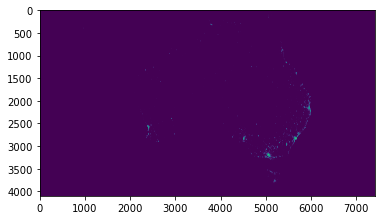

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import (ImageNormalize, LogStretch)

abs_pop_file = 'APG20e_1_0_0.tif'
abs_pop_read = rasterio.open(abs_pop_file)
abs_pop_grid = abs_pop_read.read(1).astype('int64')
mask = abs_pop_read.dataset_mask()
crs = abs_pop_read.crs
abs_pop_data = abs_pop_grid * mask
plt.imshow(abs_pop_data, norm=ImageNormalize(abs_pop_data, stretch=LogStretch()))

Now, we establish a function from drawing from this distribution:

In [3]:
import numpy.random as rand

# Make grids of x and y coordinates corresponding to every pixel of the data.
coords_x, coords_y = np.meshgrid(np.arange(abs_pop_data.shape[1]), np.arange(abs_pop_data.shape[0]))
# Flatten these grids, so that they may be sampled from by rand.choice
coords_x_flat = coords_x.flatten()
coords_y_flat = coords_y.flatten()
# Build an array of weights from the population data, and normalise to sum = 1
probabilities = abs_pop_data.flatten() / abs_pop_data.sum()
# Array of indices to actually draw from using rand.choice
index_list = np.arange(len(coords_x_flat))

def draw_from_population(n: int = 100):
    # Choose n indices from the index list, using the population probabilities as weights.
    random_indices = rand.choice(index_list, n, p=probabilities)
    # Use index to access x and y coordinates corresponding to this index.
    x = coords_x_flat[random_indices]
    y = coords_y_flat[random_indices]
    return x, y

Test by overplotting sample of 100 drawn from this distribution; it seems consistent.

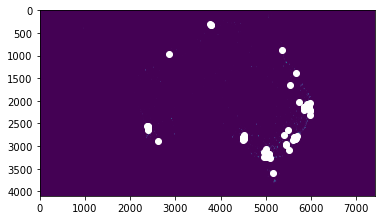

In [4]:
x, y = draw_from_population(100)
plt.imshow(abs_pop_data, norm=ImageNormalize(abs_pop_data, stretch=LogStretch()))
plt.scatter(x,y, c="white")

Because these coordinates are in the pixel space of the original GeoTIFF image, we need a means of translating them to global longitude and latitude, for compatibility with our airport data.

The following code adapted from https://rasterio.groups.io/g/main/message/315

In [5]:
import pyproj

def pixel_to_lonlat(x, y):
    lon_abs, lat_abs = (x, y) * abs_pop_read.transform
    lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)
    return lons, lats

We're then going to need a means of measuring the distance from one point in long, lat to another.

The following is adapted from my own code at https://github.com/Lachimax/pywebofworlds/blob/master/pywebofworlds/maps.py

In [12]:
abs_proj = pyproj.Proj(init="epsg:3577")
glob_proj = pyproj.Proj(init="epsg:4326")


def great_circle_ang_dist(lon1: float, lat1: float, lon2: float, lat2: float):
    """
    Calculates the great circle angular distance between two points on the map, in degrees. All units are interpreted as
    degrees unless deg is given as False, in which case all units are interpreted as radians.
    Constructed using https://en.wikipedia.org/wiki/Great-circle_distance
    :param lon1: Longitude of first point, in degrees.
    :param lat1: Latitude of first point.
    :param lon2: Longitude of second point.
    :param lat2: Latitude of second points.
    :return: float, great circle angular distance, in radians.
    """

    # Convert to radians.
    lon1 = (lon1 * un.deg).to(un.radian).value
    lon2 = (lon2 * un.deg).to(un.radian).value
    lat1 = (lat1 * un.deg).to(un.radian).value
    lat2 = (lat2 * un.deg).to(un.radian).value

    delta_lon = lon2 - lon1
    # Perform calculation.
    return np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(delta_lon))

def great_circle_distance(lon1: float, lat1: float, lon2: float, lat2: float, radius: float = 6371e3, deg: bool = True):
    """
    Calculates the great circle distance between two points on the map, in metres. All units are interpreted as degrees
    unless deg is given as False, in which case all units are interpreted as radians.
    Constructed using https://en.wikipedia.org/wiki/Great-circle_distance
    :param lon1: Longitude of first point.
    :param lat1: Latitude of first point.
    :param lon2: Longitude of second point.
    :param lat2: Latitude of second points.
    :param deg: Interpret units as degrees? If False, interprets as radians.
    :param radius: Radius of the planet, in metres.
    :return: float, great circle distance, in metres.
    """
    if type(radius) is not un.Quantity:
        radius *= un.m
    # Calculate great circle angular distance.
    ang_dist = great_circle_ang_dist(lon1=lon1, lat1=lat1, lon2=lon2, lat2=lat2)
    # Multiply by radius of planet.
    return radius.to(un.km) * ang_dist

/home/lachlan/Installations/anaconda3/envs/asa-challenge/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lachlan/Installations/anaconda3/envs/asa-challenge/lib/python3.9/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/lachlan/Installations/anaconda3/envs/asa-challenge/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<autho

Just a quick test using Sydney and Melbourne; consistent with the answer at https://www.distancecalculator.net/from-melbourne-to-sydney

Coordinates from Wikipedia.

In [13]:
lon_sydney = 151.209444
lat_sydney = -33.865

lon_melbourne = 144.963056
lat_melbourne = -37.813611

great_circle_distance(lon1=lon_sydney, lat1=lat_sydney, lon2=lon_melbourne, lat2=lat_melbourne).to(un.km)

<Quantity 713.71163611 km>

Load a (very thorough!) table of airports, including their locations. Downloaded from: https://ourairports.com/data/airports.csv

Let's plot them just to see; oh, my aren't there a lot. They trace the Earth's landmass quite nicely.

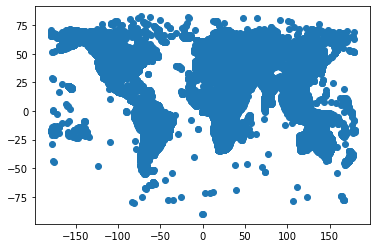

In [14]:
from astropy import table
airports = table.Table.read("airports.csv")
plt.scatter(airports['longitude_deg'], airports['latitude_deg'])

In [15]:
airports.colnames

['id',
 'ident',
 'type',
 'name',
 'latitude_deg',
 'longitude_deg',
 'elevation_ft',
 'continent',
 'iso_country',
 'iso_region',
 'municipality',
 'scheduled_service',
 'gps_code',
 'iata_code',
 'local_code',
 'home_link',
 'wikipedia_link',
 'keywords']

Let's trim this down to just the airports within our population map. We might just have to accept that some of Indonesia and New Guinea come along in the bargain.

Are there really so many airports in the Australian desert?

<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


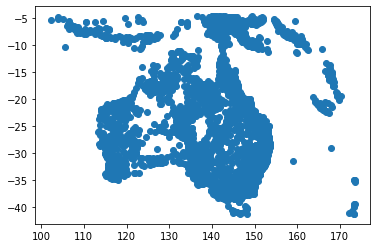

In [16]:
# First, get lon / lat of corners:
lon_min, lat_max = pixel_to_lonlat(0, 0)
lon_max, lat_min = pixel_to_lonlat(abs_pop_grid.shape[1], abs_pop_grid.shape[0])

# Use to cut the table down to size
airports_trimmed = airports[airports['longitude_deg'] < lon_max]
airports_trimmed = airports_trimmed[airports_trimmed['longitude_deg'] > lon_min]
airports_trimmed = airports_trimmed[airports_trimmed['latitude_deg'] < lat_max]
airports_trimmed = airports_trimmed[airports_trimmed['latitude_deg'] > lat_min]
plt.scatter(airports_trimmed['longitude_deg'], airports_trimmed['latitude_deg'])

We'll also limit the airports to those labelled "medium" and "large" in the data, assuming that these are the ones from which it is possible to fly to the hubs.

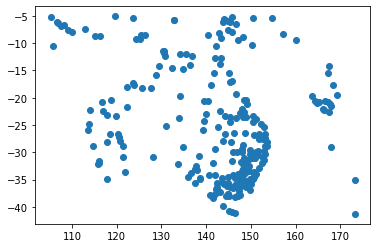

In [17]:
airports_trimmed_size = table.vstack([airports_trimmed[airports_trimmed['type'] == "medium_airport"], airports_trimmed[airports_trimmed['type'] == "large_airport"]])
plt.scatter(airports_trimmed_size['longitude_deg'], airports_trimmed_size['latitude_deg'])

Much better.

Now a function to find the nearest airport to a given point from this table:

In [18]:
def nearest_airport(lon: float, lat: float):
    distance = great_circle_distance(lon1=lon, lat1=lat, lon2=airports_trimmed_size['longitude_deg'], lat2=airports_trimmed_size['latitude_deg'])
    i = np.argmin(distance)
    return airports_trimmed_size[i], distance[i]

Test on the Sydney coordinates; presumably we will retrieve an airport in Sydney.

In [19]:
airport, dist = nearest_airport(lon_sydney, lat_sydney)
print(dist)
airport

9.5017502217421 km


id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
int64,str7,str14,str80,float64,float64,int64,str2,str2,str7,str48,str3,str4,str3,str7,str128,str128,str256
27145,YSSY,large_airport,Sydney Kingsford Smith International Airport,-33.94609832763672,151.177001953125,21,OC,AU,AU-NSW,Sydney,yes,YSSY,SYD,--,http://www.sydneyairport.com.au/,https://en.wikipedia.org/wiki/Kingsford_Smith_International_Airport,RAAF Station Mascot


Success.

Let's do the same for the nearest hub. For simplicity's sake, we'll leave out the daily commutes from hotels etc. to the hub; this would require us to pick a place for each participant to stay, which is impractical, and in any case the daily commutes should roughly cancel out between the "old" format and the "new" format.

University coordinates are from Wikipedia. Also, I guess the NZ hub never got confirmed? I also don't see any information about the Hobart hub on the event website, so I'll leave that out too.

/home/lachlan/Installations/anaconda3/envs/asa-challenge/lib/python3.9/site-packages/astropy/table/column.py:1125: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


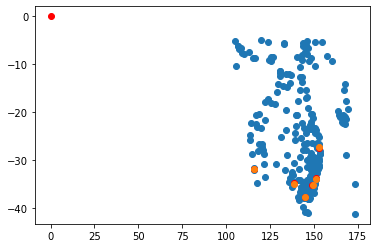

In [20]:
hubs = [
    "online",
    "adelaide",
    "brisbane",
    "canberra",
    "melbourne",
    "perth",
    "sydney"
]

hub_lons = np.array([
    0.0,
    138.605361,
    153.013056,
    149.006944,
    144.9614,
    115.893333,
    151.187222
])

hub_lats = np.array([
    0.0,
    -34.920667,
    -27.497222,
    -35.320278,
    -37.7963,
    -32.006111,
    -33.887778    
])

hub_nearest_airports = table.Table(names=airports.colnames, dtype=airports.dtype)
for i in range(len(hubs)):
    airport, dist = nearest_airport(hub_lons[i], hub_lats[i])
    hub_nearest_airports.add_row(airport)
hub_nearest_airports[0]['longitude_deg'] = np.ma.masked
hub_nearest_airports[0]['latitude_deg'] = np.ma.masked

plt.scatter(airports_trimmed_size['longitude_deg'], airports_trimmed_size['latitude_deg'])
plt.scatter(hub_lons, hub_lats, c="red")
plt.scatter(hub_nearest_airports['longitude_deg'], hub_nearest_airports['latitude_deg'])

def nearest_hub(lon: float, lat: float):
    distance = great_circle_distance(lon1=lon, lat1=lat, lon2=hub_lons, lat2=hub_lats)
    i = np.argmin(distance)
    return i, distance[i]

According to the ABS, the proportion of commuters using modes of transport are as follows. Let's use these as the approximate proportions of transport used to get to the nearest airport. Since few people walk or ride their bike to the airport, we'll fold that in to public transport.
Stats from:
https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/2071.0.55.001~2016~Main%20Features~Feature%20Article:%20Journey%20to%20Work%20in%20Australia~40

In [21]:
transport_modes = np.array(["car", "public_transport", "other"])
transport_proportions = np.array([0.79, 0.14 + 0.052, 1-np.sum([0.79, 0.14 + 0.052])])
np.sum(transport_proportions)

1.0

To obtain the relative carbon emissions, I'll use the figures in the following Climate Council report:

https://www.climatecouncil.org.au/wp-content/uploads/2017/09/FactSheet-Transport.pdf (p6)

We're going to have to assume that people travel as the crow flies; if I had time I might attempt to hook into the Google Maps API and calculate routes using that. Instead, I'll lean toward higher emission figures in an attempt to balance it out. For the unlisted "other" category I'll just take a mean of the others.

In [22]:
carbon_car_avg = (184 * un.gram / un.km)
carbon_car_avg

<Quantity 184. g / km>

For public transport, we'll approximate by take an average between trains, light rail and bus.

In [23]:
carbon_publictransport_avg = np.mean([21, 22, 22]) * un.gram / un.km
carbon_publictransport_avg

<Quantity 21.66666667 g / km>

In [24]:
transport_carbon = un.Quantity([carbon_car_avg, carbon_publictransport_avg, 0  * un.gram / un.km])
transport_carbon = np.append(transport_carbon, transport_carbon.mean())
transport_carbon

<Quantity [184.        ,  21.66666667,   0.        ,  68.55555556] g / km>

Set up function for drawing from these proportions.

In [25]:
def choose_local_transport(n=100):
    indices = rand.choice(np.arange(len(transport_modes)), n, p=transport_proportions)
    return transport_modes[indices], transport_carbon[indices]

Test:

(array([80.,  0.,  0.,  0.,  0., 19.,  0.,  0.,  0.,  1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

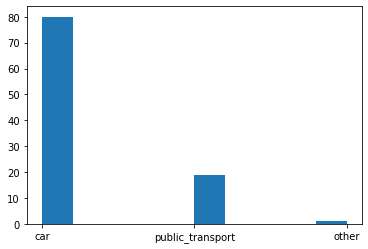

In [26]:
modes, _ = choose_local_transport()
plt.hist(modes)

According to the ICCT report on emissions from commercial aviation, the approximate CO2 emissions per passenger on domestic flights in 97 g / km.
https://theicct.org/sites/default/files/publications/CO2-commercial-aviation-oct2020.pdf (p20)

In [27]:
carbon_flight = 97 * un.gram / un.km

In [28]:
def total_carbon(x: int, y: int, hub: bool, verbose: bool = False):
    lon, lat = pixel_to_lonlat(x, y)
    if verbose:
        print("Participant lives at", lon, lat)
    airport, dist_airport = nearest_airport(lon, lat)
    if verbose:
        print("Participant's nearest airport is", airport["name"], "," , dist_airport, "away.")
    if hub:
        hub_index, dist_hub = nearest_hub(lon, lat)
    else:
        hub_index = 4
        dist_hub = great_circle_distance(lon1=lon, lat1=lat, lon2=hub_lons[hub_index], lat2=hub_lats[hub_index])
    hub = hubs[hub_index]
    hub_airport = hub_nearest_airports[hub_index]
    if verbose:
        print("Participant's nearest hub is", hub, "," , dist_hub, "away.")


    # No sense taking a plane if you live in the city already, or nearby. We'll make an arbitrary cutoff for flying.
    cutoff = 70 * un.km
    if dist_hub < cutoff:
        if verbose:
            print(f"Participant doesn't have to fly since they live closer than {cutoff} to the hub.")
        carbon_to_airport = 0 * un.gram
        carbon_to_hub = 0 * un.gram
    elif dist_hub < dist_airport:
        if verbose:        
            print("Participant shouldn't fly since they live closer to the hub than to the nearest airport.")
        carbon_to_airport = 0 * un.gram
        carbon_to_hub = 0 * un.gram
    elif airport["name"] == hub:
        if verbose:
            print("Participant shouldn't fly since the nearest airport to the hub is the same as their nearest airport.")
        carbon_to_airport = 0 * un.gram
        carbon_to_hub = 0 * un.gram
    else:
        mode_to_airport, carbon_per_km_to_airport = choose_local_transport(1)
        carbon_to_airport = (dist_airport * carbon_per_km_to_airport).to(un.gram)
        if verbose:
            print("Participant takes", mode_to_airport[0], "to the airport, using", carbon_to_airport, "of carbon.")
        dist_flight = great_circle_distance(lon1=airport["longitude_deg"], 
                                            lat1=airport["latitude_deg"],
                                            lon2=hub_airport["longitude_deg"],
                                            lat2=hub_airport["latitude_deg"]
                                           )
        carbon_to_hub = (dist_flight * carbon_flight).to(un.gram)
        if verbose:
            print("Participant flies", dist_flight, "to", hub_airport["name"], ", using", carbon_to_hub, "of carbon.")
    total = carbon_to_airport + carbon_to_hub
    if verbose:
        print("Participant is responsible for", total.to(un.kg), "total carbon emissions.")
    return total, hub_index

Let's take a single dummy participant, to try everything out. Going to the nearest hub:

In [29]:
x, y = draw_from_population(1)
total_hub, _ = total_carbon(x, y, hub = True, verbose = True)

Participant lives at [150.82485066] [-33.74642103]
Participant's nearest airport is RAAF Base Richmond , 16.714358725996217 km away.
Participant's nearest hub is sydney , 36.98323795966812 km away.
Participant doesn't have to fly since they live closer than 70.0 km to the hub.
Participant is responsible for 0.0 kg total carbon emissions.


<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


Or going to Melbourne:

In [30]:
total_melbourne, _ = total_carbon(x, y, hub = False, verbose = True)

Participant lives at [150.82485066] [-33.74642103]
Participant's nearest airport is RAAF Base Richmond , 16.714358725996217 km away.
Participant's nearest hub is melbourne , [694.43886343] km away.
Participant takes car to the airport, using [3075.44200558] g of carbon.
Participant flies 701.6581188882418 km to Melbourne Essendon Airport , using 68060.83753215945 g of carbon.
Participant is responsible for [71.13627954] kg total carbon emissions.


<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


In [31]:
print("This person saved", (total_melbourne - total_hub).to(un.kg), "of carbon emissions under the new scheme.")

This person saved [71.13627954] kg of carbon emissions under the new scheme.


According to the ASA ASM 2021 website, the hub attendance is as follows:

Total participants: 447
Total in-person participants: 337


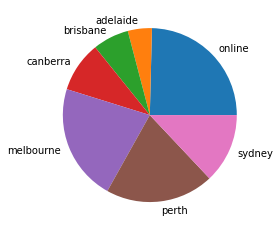

In [32]:
attendance = [
    110,
    20,
    30,
    42,
    97,
    90,
    58]

plt.pie(attendance, labels=hubs)

total_participants = np.sum(attendance)
print("Total participants:", total_participants)
total_in_person = total_participants - attendance[0]
print("Total in-person participants:", total_in_person)

At first, we'll try a naive approach not taking final hub attendance into account, and simply draw 447 people from the Australian population.

<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


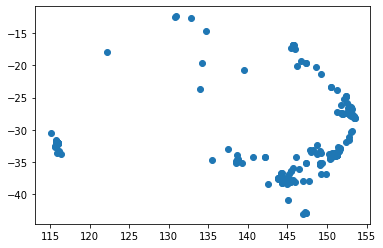

In [33]:
xs, ys = draw_from_population(total_in_person)
lons, lats = pixel_to_lonlat(xs, ys)
plt.scatter(lons, lats)

<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


Total carbon savings for the hub model are [29326.25298712] kg


([<matplotlib.patches.Wedge at 0x7f860eda3670>,
 [Text(0.7873249816504768, 0.7681922762362796, 'online'),
  Text(-0.16558449344608986, 1.0874657583253837, 'adelaide'),
  Text(-0.9138104811838688, 0.6123319397830774, 'brisbane'),
  Text(-1.0843886581596227, -0.18466520531700928, 'canberra'),
  Text(-0.7139517925146047, -0.8368230625198991, 'melbourne'),
  Text(0.18847471262949597, -1.0837330311009392, 'perth'),
  Text(0.9347597589562907, -0.5798484224657141, 'sydney')])

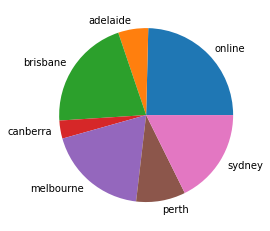

In [34]:
nearest_hubs = np.zeros(len(hubs))
total_carbon_hub = un.Quantity([0 * un.kg])
total_carbon_melbourne = un.Quantity([0 * un.kg])

for i in range(len(xs)):
    x = xs[i]
    y = ys[i]
    total, hub_index = total_carbon(x, y, hub = True, verbose = False)
    total_carbon_hub += total
    nearest_hubs[hub_index] += 1
    total, _ = total_carbon(x, y, hub = False, verbose = False)
    total_carbon_melbourne += total
    
nearest_hubs[0] = attendance[0]
print("Total carbon savings for the hub model are", total_carbon_melbourne - total_carbon_hub)
plt.pie(nearest_hubs, labels=hubs)

I've calculated the above pie chart to show that this approach roughly reproduces the attendance per hub (although not perfectly). However, if we do want to be closer to the actual hub attendance numbers, we can do something like this (the below cell will take quite a while to run fully, and it will take longer the closer it gets to the goal, but have faith):

<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


Participants found: 111.0
Participants found: 112.0
Participants found: 113.0
Participants found: 114.0
Participants found: 115.0
Participants found: 116.0
Participants found: 117.0
Participants found: 118.0
Participants found: 119.0
Participants found: 120.0
Participants found: 121.0
Participants found: 122.0
Participants found: 123.0
Participants found: 124.0
Participants found: 125.0
Participants found: 126.0
Participants found: 127.0
Participants found: 128.0
Participants found: 129.0
Participants found: 130.0
Participants found: 131.0
Participants found: 132.0
Participants found: 133.0
Participants found: 134.0
Participants found: 135.0
Participants found: 136.0
Participants found: 137.0
Participants found: 138.0
Participants found: 139.0
Participants found: 140.0
Participants found: 141.0
Participants found: 142.0
Participants found: 143.0
Participants found: 144.0
Participants found: 145.0
Participants found: 146.0
Participants found: 147.0
Participants found: 148.0
Participants

Participants found: 356.0
Participants found: 357.0
Participants found: 357.0
Participants found: 357.0
Participants found: 357.0
Participants found: 357.0
Participants found: 357.0
Participants found: 357.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 358.0
Participants found: 359.0
Participants found: 359.0
Participants found: 360.0
Participants found: 360.0
Participants found: 360.0
Participants found: 361.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 362.0
Participants found: 363.0
Participants found: 364.0
Participants found: 364.0
Participants

Participants found: 403.0
Participants found: 403.0
Participants found: 403.0
Participants found: 403.0
Participants found: 403.0
Participants found: 403.0
Participants found: 403.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 404.0
Participants found: 405.0
Participants found: 405.0
Participants found: 405.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants found: 406.0
Participants

Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 439.0
Participants found: 440.0
Participants found: 440.0
Participants found: 441.0
Participants found: 441.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 442.0
Participants found: 443.0
Participants found: 443.0
Participants found: 443.0
Participants found: 443.0
Participants found: 444.0
Participants found: 444.0
Participants found: 445.0
Participants found: 445.0
Participants found: 445.0
Participants found: 445.0
Participants found: 445.0
Participants found: 445.0
Participants found: 445.0
Participants found: 445.0
Participants

([<matplotlib.patches.Wedge at 0x7f860ed0ba00>,
 [Text(0.7873249816504768, 0.7681922762362796, 'online'),
  Text(-0.12727564751046372, 1.0926119665969216, 'adelaide'),
  Text(-0.4955972675344321, 0.9820302176676666, 'brisbane'),
  Text(-0.909484364832649, 0.618739193946006, 'canberra'),
  Text(-1.0217262869562427, -0.4075234895593254, 'melbourne'),
  Text(0.13495155950559648, -1.0916904673885395, 'perth'),
  Text(1.0098675722275425, -0.4360819722979263, 'sydney')])

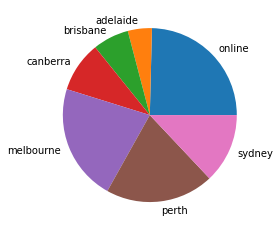

In [35]:
participant_list = []
participants = np.zeros(len(attendance))
participants[0] = attendance[0]

while participants.sum() < sum(attendance):
    x, y = draw_from_population(1)
    lon, lat = pixel_to_lonlat(x, y)
    hub_index, _ = nearest_hub(lon=lon, lat=lat)
    if participants[hub_index] < attendance[hub_index]:
        participant_list.append((x,y))
        participants[hub_index] += 1
    print("Participants found:", participants.sum())
plt.pie(participants, labels=hubs)

We've forced the same proportion of hub attendance as the final registration by accepting only enough samples to meet that quota. Now run the carbon sum with this sample:

In [36]:
carbon_hub = un.Quantity([0 * un.kg])
carbon_melbourne = un.Quantity([0 * un.kg])

for i, xy in enumerate(participant_list):
    x, y = xy
    total, _ = total_carbon(x, y, hub = True, verbose = False)
    if not np.isnan(total):
        carbon_hub += total
    total, _ = total_carbon(x, y, hub = False, verbose = False)
    if not np.isnan(total):
        carbon_melbourne += total
    
print("Total carbon savings for the hub model are", carbon_melbourne - carbon_hub)

<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


Total carbon savings for the hub model are [33452.10934393] kg


We could try to consider things such as screen energy useage at the hubs, but I'm running out of time. I would also try accounting for the amount of carbon used by those participating online due to their computer useage, which is higher due to the lockdowns, but I've decided to calculate this number "without lockdown". This should cancel out anyway if both hub and central approaches were calculated "with lockdown" this way. The other weakness of my approach is that the geographic distribution of academics is probably not quite the same as the Australian population at large, most likely being concentrated near universities. This is difficult to take into account, but could be done, I think, with a lot more time.

In [44]:
carbon_melbourne[0] - carbon_hub[0]

<Quantity 33452.10934393 kg>

Now, we wouldn't be scientists if we didn't put error bars on that!

For some statistical robustness, let's do a brute-force Monte Carlo experiment with 100 trials. I will use the former methodology, without forcing hub attendance to their true percentages, because doing it the way just above would be time-prohibitive. The answer is of the same order of magnitude anyway, although it does seem to skew lower for the unforced method. (This will also take a long time to run)

In [40]:
savings = []

for j in range(100):

    total_carbon_hub = un.Quantity([0 * un.kg])
    total_carbon_melbourne = un.Quantity([0 * un.kg])
    
    xs, ys = draw_from_population(total_in_person)
    lons, lats = pixel_to_lonlat(xs, ys)

    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        total, hub_index = total_carbon(x, y, hub = True, verbose = False)
        total_carbon_hub += total
        nearest_hubs[hub_index] += 1
        total, _ = total_carbon(x, y, hub = False, verbose = False)
        total_carbon_melbourne += total
    
    saving = total_carbon_melbourne[0] - total_carbon_hub[0]
    print(f"Total savings for trial {j}: {saving}")
    savings.append(saving)

<ipython-input-5-8ac290c5f899>:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon_abs, lat_abs = (x, y) * abs_pop_read.transform
<ipython-input-5-8ac290c5f899>:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lons, lats = pyproj.transform(abs_proj, glob_proj, lon_abs, lat_abs)


Total savings for trial 0: [27060.94247642] kg
Total savings for trial 1: [28423.43149315] kg
Total savings for trial 2: [25687.23476901] kg
Total savings for trial 3: [25963.82531796] kg
Total savings for trial 4: [26847.57733867] kg
Total savings for trial 5: [24215.15542315] kg
Total savings for trial 6: [24906.42511645] kg
Total savings for trial 7: [24841.31962986] kg
Total savings for trial 8: [26804.9643444] kg
Total savings for trial 9: [23757.35157343] kg
Total savings for trial 10: [28559.03014535] kg


<ipython-input-12-3c19d7d26ef7>:25: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(delta_lon))


Total savings for trial 11: [nan] kg
Total savings for trial 12: [26088.0642345] kg
Total savings for trial 13: [27004.50716907] kg
Total savings for trial 14: [27845.66267649] kg
Total savings for trial 15: [27257.80140222] kg
Total savings for trial 16: [26271.77860334] kg
Total savings for trial 17: [26604.30825845] kg
Total savings for trial 18: [25312.1200703] kg
Total savings for trial 19: [24598.99788068] kg
Total savings for trial 20: [28223.93939702] kg
Total savings for trial 21: [25204.8969239] kg
Total savings for trial 22: [26676.85329289] kg
Total savings for trial 23: [27181.24899888] kg
Total savings for trial 24: [28749.89096029] kg
Total savings for trial 25: [26280.2130175] kg
Total savings for trial 26: [24934.27232734] kg
Total savings for trial 27: [29705.21971572] kg
Total savings for trial 28: [24554.00274868] kg
Total savings for trial 29: [28652.40085251] kg
Total savings for trial 30: [26869.74272458] kg
Total savings for trial 31: [26214.43030132] kg
Total s

(array([ 4.,  6., 16., 14., 19., 15.,  8.,  7.,  4.,  5.]),
 array([23380.18216179, 24042.69651544, 24705.21086909, 25367.72522274,
        26030.23957639, 26692.75393003, 27355.26828368, 28017.78263733,
        28680.29699098, 29342.81134462, 30005.32569827]),
 <BarContainer object of 10 artists>)

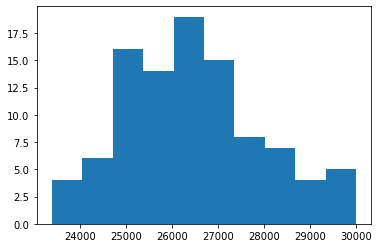

In [46]:
plt.hist(np.array(savings))

Looks pretty Gaussian, thankfully.

In [49]:
print("Median value:")
median = np.nanmedian(np.array(savings))
median

Median value:


26317.991563391108

In [50]:
print("Mean value:")
mean = np.nanmean(np.array(savings))
mean

Mean value:


26463.361052082648

In [52]:
print("Standard deviation:")
sigma = np.nanstd(np.array(savings))
sigma

Standard deviation:


1462.4033657408402

For our 95% confidence answer, let's then take:

In [55]:
print(f"{np.round(mean)} ± {2 * np.round(sigma)} kg")

26463.0 ± 2924.0 kg


Or 26,000 ± 3,000 kg
**QED**